In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torchvision
from torchvision.utils import make_grid
import time

from csgm import ConditionalScoreModel2D, ConditionalScoreModel2Dy
from csgm.utils import CustomLRScheduler

from utils_ours import uncond_loss_fn, our_loss_fn
from samplers import *

from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import functools
import math

In [ ]:
T = 1

size = 175

dataset_str = "Celeb" #@param ['LIDC', 'MNIST'] {'type':'string'}


eps = 5e-3
device = "cuda"

inv_prob = "deblurr3d"#@param ['ct', 'deblurr'] {'type':'string'}


batch_size = 100
num_samples = 1000#@param {"type":"integer"}

saved_samples = 10

## Parameters below are fixed for our experiment. Changing them will require training a new model for our approach.


sig_blurr = 5

max_angle = 45
color_channels = 1

#angles = int(size * max_angle / 180.)
angles = size

num_steps = 1000

if dataset_str == "MNIST": 
    ## learning rate
    lr= 0.002 #@param {'type':'number'}
    lr_final = 0.0005
    modes = 15
    hidden_dim = 32
    from torchvision.datasets import MNIST

    dataset = MNIST('.', 
                train=False, 
                transform=torchvision.transforms.Compose(
                    [#torchvision.transforms.Resize(32),
                     torchvision.transforms.ToTensor(), 
                     torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))]),
                download=True)
    val_data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
    sig_obs = 0.05
elif dataset_str == "Celeb": 
    modes = 50
    hidden_dim = 128

    dataset = torchvision.datasets.CelebA(root = "/fabian/work/Project CT Diffusion/SBD-task--/SBD-task-dependent-main/dataset/celeba/",
                                          split = "valid", transform=torchvision.transforms.Compose(
                    [torchvision.transforms.Resize((size, size)),
                     torchvision.transforms.ToTensor(), 
                     torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))]))
    val_data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    sig_obs = 0.01
    
elif dataset_str == "LIDC":
    lr= 0.002 #@param {'type':'number'}
    lr_final = 0.0005
    modes = 25
    hidden_dim = 32
    from utils_ours import LungDataset

    dataset = LungDataset(train = True,
                       transform=torchvision.transforms.Compose(
                           [torchvision.transforms.Resize(size, antialias=True), torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))]))

    val_data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
    sig_obs = 0.05
elif dataset_str == "GP":
    modes = 25
    hidden_dim = 32
    from utils_ours import GP
    dataset = GP(train = False, size = size)
                       #transform=torchvision.transforms.Compose(
                       #    [torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))]))

    val_data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
    sig_obs = 0.05
        

In [ ]:
# @title Load the score-based model


if True:
    #prepare forward map and other required parameters
    if inv_prob == "deblurr" or inv_prob == "deblurr3d":
        from utils_ours import build_blurring_operator
        A = build_blurring_operator(size, sig_blurr).to(device)
    elif inv_prob == "ct":
        from utils_ours import build_CT_operator
        try:
            A = torch.load("CT_forward" + str(size) + "angles" + str(angles) + "max_angle" + str(max_angle) +".pt")
        except:
            print("Building Forward map")
            A = build_CT_operator(size, angles, max_angle) 
        A = torch.from_numpy(A).to(device).float()


## Generate Measurement

In [ ]:
%matplotlib inline

torch.manual_seed(1)
#torch.manual_seed(3)
#torch.manual_seed(4)
torch.manual_seed(33)

if dataset_str == 'MNIST' or dataset_str == "Celeb":
    true, _ = next(iter(val_data_loader))
else:
    true = next(iter(val_data_loader))


plt.imshow(true[0, :, :, :])
plt.grid(None) 
plt.axis('off')
plt.savefig("images/Deblurring/truth2.jpg")
plt.colorbar()
plt.show()

true = true.cuda()

In [ ]:

if inv_prob == "ct":
    y = A.float() @ true.flatten().to(A.device).float()
    y = y.reshape((1, size, angles))
elif inv_prob == "deblurr":
    y = A.float() @ true.flatten().to(A.device).float()
    y = y.reshape((1, size, size))
elif inv_prob == "deblurr3d":
    y = A.float() @ true.reshape((-1, 3)).to(A.device).float()
    y = y.reshape((size, size, 3))
    
y = y + sig_obs * torch.randn_like(y)
y = y.cuda().float()

sample_grid = make_grid(y / torch.max(y), nrow=1)

plt.imshow(y.cpu())
plt.axis('off')
#plt.imshow(sample_grid.permute(1, 2, 0).cpu())
plt.savefig("images/Deblurring/measurement2.jpg")
plt.colorbar()
plt.show()

## Generate Posterior samples

In [ ]:
d3 = inv_prob == "deblurr3d"

if d3:
    color_channels = 3

filename = "unconditional" + "_" + "T=" + str(T)+ "_" + dataset_str + str(size)+ str(hidden_dim)

uncond_score_model = ConditionalScoreModel2D(
        modes=modes,
        hidden_dim=hidden_dim,
        nlayers=12,
        nt=T,
        d3 = d3
    ).to(device)

cond_score_model = ConditionalScoreModel2Dy(
        modes=modes,
        hidden_dim=hidden_dim,
        nlayers=12,
        nt=T,
        d3 = d3
    ).to(device)

our_score_model = ConditionalScoreModel2D(
        modes=modes,
        hidden_dim=hidden_dim,
        nlayers=12,
        nt=T,
        d3 = d3
        #norm_layersize = size
    ).to(device)


ckpt = torch.load(os.path.join("cpts","ckpt_trained_" + filename + ".pth"), map_location=device)
uncond_score_model.load_state_dict(ckpt)

if inv_prob == "ct":
    filename = "ours" + "_" + "T=" + str(T)+ "_" + dataset_str + inv_prob + str(max_angle) + str(size)+ str(hidden_dim)
    ckpt = torch.load(os.path.join("cpts","ckpt_trained_" + filename + ".pth"), map_location=device)
    our_score_model.load_state_dict(ckpt)

    filename = "conditional" + "_" + "T=" + str(T)+ "_" + dataset_str + inv_prob + str(max_angle)+ str(size)+ str(hidden_dim)
    ckpt = torch.load(os.path.join("cpts","ckpt_trained_" + filename + ".pth"), map_location=device)
    cond_score_model.load_state_dict(ckpt)
elif inv_prob == "deblurr" or inv_prob == "deblurr3d":
    filename = "ours" + "_" + "T=" + str(T)+ "_" + dataset_str + inv_prob + str(sig_blurr)+ str(size) + str(hidden_dim)
    ckpt = torch.load(os.path.join("cpts","ckpt_trained_" + filename + ".pth"), map_location=device)
    our_score_model.load_state_dict(ckpt)

    filename = "conditional" + "_" + "T=" + str(T)+ "_" + dataset_str + inv_prob + str(sig_blurr)+ str(size) + str(hidden_dim)
    ckpt = torch.load(os.path.join("cpts","ckpt_trained_" + filename + ".pth"), map_location=device)
    cond_score_model.load_state_dict(ckpt)


cond_score_model.eval()
our_score_model.eval()
uncond_score_model.eval()

pass

In [ ]:
## Generate samples using the specified sampler.
start = time.time()
samples = ALD_sampler(uncond_score_model, 
                  T,
                  y = y[None, ...].repeat((batch_size, 1, 1, 1)),
                  A = A, 
                  sig_obs = sig_obs,
                  nsamples = num_samples,
                  batch_size = batch_size, 
                  num_steps = num_steps,
                  eps = eps,
                  size = size,
                  color_channels = 3,
                  device=device)

time_ald = time.time() - start
print("time elapsed:", time_ald)
## Sample visualization.
#samples = samples.clamp(0.0, 1.0)
%matplotlib inline
#samples = samples.reshape((100, size, size, 3))
#samples = samples.permute(0, 3, 1, 2)
sample_grid = make_grid(samples, nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu())
#plt.imshow(sample_grid.reshape((342, 342, 3)).cpu())
plt.show()

std_ald = torch.sum(torch.std(samples, axis = 0)**2, axis = 0)**0.5
#bias_ald = torch.sum((torch.mean(samples, axis = 0) - true.to(samples.device)[0, :, :, :].permute(2, 1, 0))**2, axis = 0)**0.5
bias = torch.mean(samples, axis = 0).permute(2, 1, 0).cpu().transpose(0, 1) - true.to(samples.device)[0, :, :, :].cpu()
bias_ald = torch.sum(bias**2, axis = 2)**0.5

l2_ald = torch.mean((samples.cuda() - true.to(samples.device)[0, :, :, :].permute(2, 0, 1))**2)**0.5

plt.imshow(bias_ald.cpu())
plt.title("bias")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0).cpu().detach().permute(1, 2, 0))
plt.title("mean")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(std_ald.cpu().detach())
plt.title("std")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
samples_ald = samples[0:saved_samples, :, :, :]

print("std:" , torch.mean(std_ald**2)**0.5, "bias:", torch.mean(bias_ald**2)**0.5, "l2:", l2_ald)


In [ ]:
#tune hyperparameter
dpmbs = 50
params = [0.1, 1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 5000]
res = torch.zeros(len(params))
for i, p in enumerate(params):
    samples = DPM_sampler(uncond_score_model, 
                  T = T,
                  y = y[None, ...].repeat((dpmbs, 1, 1, 1)),
                  A = A, 
                  sig_obs = sig_obs,
                  nsamples = dpmbs,
                  p = p,
                  batch_size = dpmbs, 
                  num_steps = 300,
                  eps = eps,
                  size = size,
                  color_channels = 3,
                  device=device)
    std = torch.std(samples, axis = 0)
    bias = (torch.mean(samples, axis = 0).permute(1,2,0) - true.to(samples.device)[0, :, :, :])
    res[i] = torch.sum(std**2) + torch.sum(bias**2)
    #print("p:", p, "res:", res[i])
    #samples = samples.clamp(0.0, 1.0)
    #%matplotlib inline
    #sample_grid = make_grid(samples, nrow=int(np.sqrt(dpmbs)))
    
    #plt.figure(figsize=(15,15))
    #plt.axis('off')
    #plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    #plt.show()
    


p = params[torch.argmin(res)]    
## Generate samples using the specified sampler.
start = time.time()
samples = DPM_sampler(uncond_score_model, 
                  T = T,
                  y = y[None, ...].repeat((dpmbs, 1, 1, 1)),
                  A = A, 
                  sig_obs = sig_obs,
                  nsamples = num_samples,
                  p = p,
                  batch_size = dpmbs, 
                  num_steps = num_steps,
                  eps = eps,
                  size = size,
                  color_channels = 3,
                  device=device)
time_dpm = time.time() - start
print("time elapsed:", time_dpm)
## Sample visualization.p
#samples = samples.clamp(0.0, 1.0)
%matplotlib inline
sample_grid = make_grid(samples, nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow((sample_grid.permute(1, 2, 0).cpu() - torch.min(sample_grid).cpu()) / (torch.max(sample_grid)- torch.min(sample_grid)).cpu(), cmap = 'gray')
plt.show()

std_dpm = torch.sum(torch.std(samples, axis = 0)**2, axis = 0)**0.5
#bias_cond = torch.sum((torch.mean(samples, axis = 0) - true.to(samples.device)[0, :, :, :].permute(2, 1, 0))**2, axis = 0)**0.5
bias = torch.mean(samples, axis = 0).permute(2, 1, 0).cpu().transpose(0, 1) - true.to(samples.device)[0, :, :, :].cpu()
bias_dpm = torch.sum(bias**2, axis = 2)**0.5

l2_dpm = torch.mean((samples.cuda() - true.to(samples.device)[0, :, :, :].permute(2, 0, 1))**2)**0.5

plt.imshow(bias_dpm.detach().cpu())
plt.title("bias")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0).cpu().detach().permute(1, 2, 0))
plt.title("mean")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(std_dpm.detach().cpu())
plt.title("std")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
samples_dpm = samples[0:saved_samples, :, :, :]

print("std:" , torch.mean(std_dpm**2)**0.5, "bias:", torch.mean(bias_dpm**2)**0.5, "l2:", l2_dpm)

In [ ]:
#tune hyperparameter
dpmbs = 5
params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
res = torch.zeros(len(params))
for i, param in enumerate(params):
    samples = Projection_sampler(uncond_score_model, 
                  lamb = param, 
                  T = T,
                  y = y[None, ...].repeat((dpmbs, 1, 1, 1)),
                  A = A, 
                  sig_obs = sig_obs,
                  nsamples = dpmbs,
                  batch_size = dpmbs, 
                  num_steps = 100,
                  eps = eps,
                  size = size,
                  color_channels = 3,
                  device=device,
                  iterative = False)
    std = torch.std(samples, axis = 0)
    bias = (torch.mean(samples, axis = 0).permute(1,2,0) - true.to(samples.device)[0, :, :, :])
    res[i] = torch.sum(std**2) + torch.sum(bias**2)

param = params[torch.argmin(res)]    

## Generate samples using the specified sampler.
start = time.time()
samples = Projection_sampler(uncond_score_model, 
                  lamb = param,
                  T = T,
                  y = y[None, ...].repeat((dpmbs, 1, 1, 1)),
                  A = A, 
                  sig_obs = sig_obs,
                  nsamples = num_samples //10,
                  batch_size = dpmbs, 
                  num_steps = num_steps,
                  eps = eps,
                  size = size,
                  color_channels = 3,
                  device=device,
                  iterative = False)
time_proj = (time.time() - start) * 10
print("time elapsed:", time_proj)
## Sample visualization.p
#samples = samples.clamp(0.0, 1.0)
%matplotlib inline
sample_grid = make_grid(samples, nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow((sample_grid.permute(1, 2, 0).cpu() - torch.min(sample_grid).cpu()) / (torch.max(sample_grid)- torch.min(sample_grid)).cpu(), cmap = 'gray')
plt.show()

std_proj = torch.sum(torch.std(samples, axis = 0)**2, axis = 0)**0.5
#bias_cond = torch.sum((torch.mean(samples, axis = 0) - true.to(samples.device)[0, :, :, :].permute(2, 1, 0))**2, axis = 0)**0.5
bias = torch.mean(samples, axis = 0).permute(2, 1, 0).cpu().transpose(0, 1) - true.to(samples.device)[0, :, :, :].cpu()
bias_proj = torch.sum(bias**2, axis = 2)**0.5

l2_proj = torch.mean((samples.cuda() - true.to(samples.device)[0, :, :, :].permute(2, 0, 1))**2)**0.5

plt.imshow(bias_proj.detach().cpu())
plt.title("bias")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0).cpu().detach().permute(1, 2, 0))
plt.title("mean")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(std_proj.detach().cpu())
plt.title("std")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
samples_proj = samples[0:saved_samples, :, :, :]

print("std:" , torch.mean(std_proj**2)**0.5, "bias:", torch.mean(bias_proj**2)**0.5, "l2:", l2_proj)


In [ ]:
## Generate samples using the specified sampler.
start = time.time()
samples = cond_sampler(cond_score_model, 
                  T = T,
                  y = y[None, ...].repeat((batch_size, 1, 1, 1)),
                  A = A, 
                  sig_obs = sig_obs,
                  nsamples = num_samples,
                  batch_size = batch_size, 
                  size = size,
                  num_steps = num_steps,
                  color_channels = 3,
                  device=device,
                  eps = eps)

time_cond = time.time() - start
print("time elapsed:", time_cond)
## Sample visualization.p
samples = samples.clamp(0.0, 1.0)
%matplotlib inline

samples = samples.reshape((num_samples, size, size, 3))
samples = samples.permute(0, 3, 1, 2)
sample_grid = make_grid(samples, nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu())
#plt.imshow(sample_grid.reshape((342, 342, 3)).cpu())
plt.show()

std_cond = torch.sum(torch.std(samples, axis = 0)**2, axis = 0)**0.5
#bias_cond = torch.sum((torch.mean(samples, axis = 0) - true.to(samples.device)[0, :, :, :].permute(2, 1, 0))**2, axis = 0)**0.5
bias = torch.mean(samples, axis = 0).permute(2, 1, 0).cpu().transpose(0, 1) - true.to(samples.device)[0, :, :, :].cpu()
bias_cond = torch.sum(bias**2, axis = 2)**0.5

l2_cond = torch.mean((samples.cuda() - true.to(samples.device)[0, :, :, :].permute(2, 0, 1))**2)**0.5

plt.imshow(bias_cond.cpu())
plt.title("bias")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0).cpu().detach().permute(1, 2, 0))
plt.title("mean")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(std_cond.cpu().detach())
plt.title("std")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
samples_cond = samples[0:saved_samples, :, :, :]

print("std:" , torch.mean(std_cond**2)**0.5, "bias:", torch.mean(bias_cond**2)**0.5, "l2:", l2_cond)


In [ ]:
## Generate samples using the specified sampler.
start = time.time()
samples = Our_sampler(our_score_model, 
                  T = T,
                  y = y[None, ...].repeat((batch_size, 1, 1, 1)),
                  A = A, 
                  sig_obs = sig_obs,
                  nsamples = num_samples,
                  batch_size = batch_size, 
                  size = size,
                  num_steps = num_steps,
                  color_channels = 3,
                  device=device,
                  eps = eps)
time_ours= time.time() - start
print("time elapsed:", time_ours)
## Sample visualization.p
samples = samples.clamp(0.0, 1.0)



In [ ]:

%matplotlib inline
#samples = samples.reshape((100, size, size, 3))
#samples = samples.permute(0, 3, 1, 2)
sample_grid = make_grid(samples, nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu())
#plt.imshow(sample_grid.cpu())
#plt.imshow(sample_grid.reshape((342, 342, 3)).cpu())
plt.show()

std_ours = torch.sum(torch.std(samples, axis = 0)**2, axis = 0)**0.5
#bias_ours = torch.sum((torch.mean(samples, axis = 0) - true.to(samples.device)[0, :, :, :].permute(2, 1, 0))**2, axis = 0)**0.5
bias = torch.mean(samples, axis = 0).permute(2, 1, 0).cpu().transpose(0, 1) - true.to(samples.device)[0, :, :, :].cpu()
bias_ours = torch.sum(bias**2, axis = 2)**0.5

l2_ours = torch.mean((samples.cuda() - true.to(samples.device)[0, :, :, :].permute(2, 0, 1))**2)**0.5

plt.imshow(bias_ours.cpu())
plt.title("bias")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0).cpu().detach().permute(1, 2, 0))
plt.title("mean")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(std_ours.cpu())
plt.title("std")
plt.colorbar()
plt.grid(None) 
plt.axis('off')
plt.show()
samples_ours = samples[0:saved_samples, :, :, :]

print("std:" , torch.mean(std_ours**2)**0.5, "bias:", torch.mean(bias_ours**2)**0.5, "l2:", l2_ours)


## Exporting images

var of 0.09153624322503302 for method ald
bias of 0.08775248798283011 for method ald
var of 0.08005794410414066 for method dpm
bias of 0.08719429102465862 for method dpm
var of 0.06220924839098968 for method proj
bias of 0.07853022031682048 for method proj
var of 0.0950434976993959 for method cond
bias of 0.21772941007452398 for method cond
var of 0.03454624216292877 for method ours
bias of 0.08844782318313511 for method ours


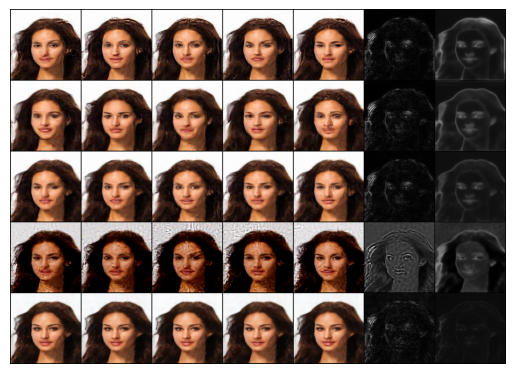

In [21]:
num_images = 5
methods = ["ald", "dpm", "proj", "cond", "ours"]

log_file_path = "images/Deblurring/output_log.txt"

samples = torch.zeros((num_images + 2) * len(methods), 3, size, size) 
biases = [bias_ald, bias_dpm, bias_proj, bias_cond, bias_ours]
stds = [std_ald, std_dpm, std_proj, std_cond, std_ours]
l2s = [l2_ald, l2_dpm, l2_proj, l2_cond, l2_ours]
times = [time_ald, time_dpm, time_proj, time_cond, time_ours]

max_std = np.max([torch.max(std).item() for std in stds])

with open(log_file_path, "w") as f:
    for method_number, samples_curr in enumerate([samples_ald, samples_dpm, samples_proj, samples_cond, samples_ours]):
        #true
        #samples[num_images + 2 +  method_number * (num_images + 2)] = true[0, :, :, :].permute(2, 0, 1)
        #std
        std = stds[method_number]
        samples[num_images + 1 + method_number * (num_images + 2)] = std / max_std
        print("var of "+ str(torch.mean(std**2).item()**0.5) + " for method " + methods[method_number])
        f.write("var of "+ str(torch.mean(std**2).item()**0.5) + " for method " + methods[method_number] + "\n")
        #bias
    
        bias = biases[method_number]#.permute(2, 1, 0)
    
        samples[num_images + method_number * (num_images + 2)] = bias #/ 3
        print("bias of "+ str(torch.mean(bias**2).item()**0.5) + " for method " + methods[method_number])
        f.write("bias of "+ str(torch.mean(bias**2).item()**0.5) + " for method " + methods[method_number] + "\n")

        f.write("time of " + str(times[method_number]) + " for method " + methods[method_number] + "\n")
        
        #print("l2 of "+ str(l2s[method_number]) + " for method " + methods[method_number])
        #samples
        for ind in range(num_images):
            samples[ind + method_number * (num_images + 2), :, :] = samples_curr[ind, :, :, :]

sample_grid = make_grid(samples.clamp(0, 1), nrow = (num_images + 2), normalize = True)
plt.grid(None) 
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu())
plt.savefig("images/Deblurring/summary2" + str(hidden_dim) + str(num_images)+ ".png", bbox_inches='tight', dpi=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


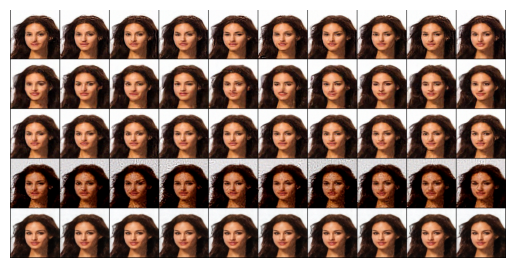

In [20]:
num_images = 10
methods = ["ald", "dpm", "proj", "cond", "ours"]

samples = torch.zeros((num_images ) * len(methods), 3, size, size) 

for method_number, samples_curr in enumerate([samples_ald, samples_dpm, samples_proj, samples_cond, samples_ours]):
    #samples
    for ind in range(num_images):
        samples[ind + method_number * (num_images), :, :] = samples_curr[ind, :, :, :]

sample_grid = make_grid(samples, nrow = (num_images))

plt.grid(None) 
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.savefig("images/Deblurring/samples" + str(hidden_dim) + str(num_images)+ ".png", bbox_inches='tight', dpi=1000)